# 가상환경 torch_cuda_yolo_env

In [21]:
# Roboflow SDK 설치 (inference-sdk 권장)
%pip install -q inference-sdk python-dotenv opencv-python matplotlib Pillow


Note: you may need to restart the kernel to use updated packages.


In [22]:
# .env 로드 및 Inference 클라이언트 준비
import os
from dotenv import load_dotenv
from inference_sdk import InferenceHTTPClient

load_dotenv()
api_key = os.getenv("ROBOFLOW_API_KEY")
assert api_key, "ROBOFLOW_API_KEY가 .env에 설정되어 있어야 합니다."

client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key=api_key,
)

# Universe 페이지 기준 프로젝트/버전 지정
workspace_slug = "roboflow-58fyf"
project_slug = "rock-paper-scissors-sxsw"
version_num = 1
# 기본 model_id는 project/version, 실패 시 workspace 포함형으로 폴백
model_id = f"{project_slug}/{version_num}"
model_id_fallback = f"{workspace_slug}/{project_slug}/{version_num}"
print("Client ready. model_id:", model_id)


Client ready. model_id: rock-paper-scissors-sxsw/1


In [23]:
# 예측 실행 예시 (inference-sdk)
# 지정하신 이미지 경로로 설정
image_path = r".data/가위바위보.png"

from pprint import pprint

# 간단 재시도 + 폴백 로직
try:
    preds = client.infer(image_path, model_id=model_id)
except Exception as e1:
    print("1차 오류:", e1)
    try:
        print("model_id 폴백 시도:", model_id_fallback)
        preds = client.infer(image_path, model_id=model_id_fallback)
    except Exception as e2:
        print("2차 오류:", e2)
        preds = None

if preds is not None:
    pprint(preds)
else:
    print("예측 실패. 네트워크 상태 또는 model_id/버전 확인 필요")


1차 오류: HTTPCallErrorError(description='502 Server Error: Bad Gateway for url: https://serverless.roboflow.com/rock-paper-scissors-sxsw/1?api_key=SF***aQ&disable_active_learning=False', api_message='Internal error. Request to Roboflow API failed.',status_code=502)
model_id 폴백 시도: roboflow-58fyf/rock-paper-scissors-sxsw/1
2차 오류: Invalid model id: roboflow-58fyf/rock-paper-scissors-sxsw/1. Expected format: project_id/model_version_id.
예측 실패. 네트워크 상태 또는 model_id/버전 확인 필요


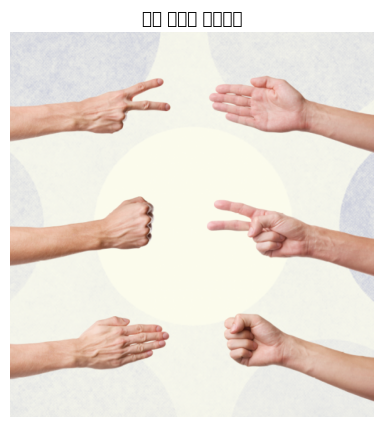

In [24]:
# 이미지 표시 (선택)
from PIL import Image
import matplotlib.pyplot as plt

try:
    img = Image.open(image_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.title('입력 이미지 미리보기')
    plt.show()
except Exception as e:
    print('이미지 표시 중 오류:', e)


In [25]:
# 추론 결과 시각화 (OpenCV)
import cv2
import numpy as np
import matplotlib.pyplot as plt

if 'preds' not in globals() or preds is None:
    print('preds가 없습니다. 예측 셀을 먼저 실행하세요.')
else:
    img = cv2.imread(image_path)
    if img is None:
        print(f'이미지를 불러올 수 없습니다: {image_path}')
    else:
        # 결과 배열 확보 (SDK 포맷 변동에 대비)
        predictions = []
        if isinstance(preds, dict):
            if 'predictions' in preds and isinstance(preds['predictions'], list):
                predictions = preds['predictions']
            elif 'results' in preds and preds.get('results') and 'predictions' in preds['results'][0]:
                predictions = preds['results'][0]['predictions']

        if not predictions:
            print('예측 결과가 비어있습니다.')
        else:
            for p in predictions:
                cls = p.get('class') or p.get('class_name') or 'unknown'
                conf = p.get('confidence') or p.get('score') or 0.0
                x = p.get('x'); y = p.get('y'); w = p.get('width'); h = p.get('height')

                if x is not None and y is not None and w is not None and h is not None:
                    x1, y1 = int(x - w/2), int(y - h/2)
                    x2, y2 = int(x + w/2), int(y + h/2)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                    cv2.putText(img, f'{cls} {conf:.4f}', (x1, max(0, y1-5)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
                else:
                    # 분류만 있는 경우: 좌상단에 라벨 표시
                    cv2.putText(img, f'{cls} {conf:.4f}', (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)

            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('예측 결과 시각화')
            plt.show()


preds가 없습니다. 예측 셀을 먼저 실행하세요.


In [26]:
# REST 폴백 (분류용) - classify.roboflow.com
# project/version 형식으로 호출. JPEG로 전송.
import requests
import os

project_slug = "rock-paper-scissors-sxsw"
version_num = 1
api_key = os.getenv("ROBOFLOW_API_KEY")

rest_url = f"https://classify.roboflow.com/{project_slug}/{version_num}?api_key={api_key}"

try:
    with open(image_path, 'rb') as f:
        resp = requests.post(rest_url, files={"file": (os.path.basename(image_path), f, "image/jpeg")}, timeout=30)
    resp.raise_for_status()
    preds = resp.json()  # 시각화 셀에서 그대로 사용 가능
    from pprint import pprint
    print("REST 폴백 성공")
    pprint(preds)
except Exception as e:
    print("REST 폴백 오류:", e)



REST 폴백 오류: 403 Client Error: Forbidden for url: https://classify.roboflow.com/rock-paper-scissors-sxsw/1?api_key=SFqOA0skEus4MuI3ahaQ
